In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

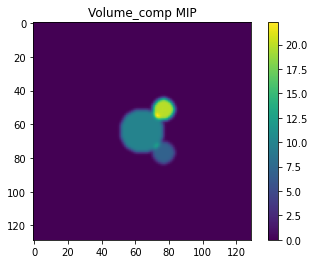

In [3]:
shape = np.array([129,129,129])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

v = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, True))

mip_z(v)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

Generate projections

In [4]:
@jax.jit
def slice_func(angles):
    return project_spatial(v, angles, dimensions)

@jax.jit
def slice_func_array(angles):
    return jnp.apply_along_axis(slice_func, 1, angles)

In [9]:
angles_true = jnp.array(np.random.rand(10000,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(angles_true)
print(time.time()-start)

imgs.shape

30.824055910110474


(10000, 129, 129)

Loss function

In [12]:
@jax.jit
def loss_func(a):
    return 1/(2* 16641) * jnp.sum((slice_func(a) - img1)**2)

@jax.jit
def loss_func_array(a):
    return 1/(2 * 16641 * angles_true.shape[0]) * jnp.sum((slice_func_array(a) - imgs)**2)

dloss = jax.jit(jax.grad(loss_func_array))

In [ ]:
start = time.time()
dloss(angles_true)
print(time.time()-start)